# Multi-Objective Hyperparameter Search

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deephyper/anl-22-summer-workshop/blob/main/notebooks/5-Multi-Objectives-Hyperparameter-Search.ipynb)

Hyperparameter search is an important part of modern ML pipelines. Often, we are not just interested in optimizing these pipelines solely for their predictive performance. One also has to take into account additional metrics when determining a good hyperparameter configuration.

[//]: # "Examples of such metrics may be multiple types of prediction performance (e.g., a good classifier must perform well with respect to accuracy, true and false positive rates, cross-entropy loss etc.); computational efficiency metrics such as number of floating-point operations, average prediction time, and model size; as well as fairness, interpretability and sparseness metrics."

Accounting for multiple metrics simultaneously results in a multi-objective hyperparameter search problem.

In this notebook, we will show to use DeepHyper to find hyperparameter configurations that simultaneously minimize both validation error and number of parameters. The latter serves as a good proxy for model size (and hence, its memory footprint), model sparsity, model efficiency (i.e., number of floating point operations), as well as its average prediction time.

The goals of this notebook are:
1. Adapt the hyperparameter search example to minimize both validation error and number of model parameters.
2. Visualize and explore alternative pareto-optimal hyperparameter configurations.
3. (Time permitting) Explore multi-objective capabilities in DeepHyper in more detail.

In [1]:
# Test if notebook is executed from Google Colab
IN_COLAB = False
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print("In Colab:", IN_COLAB)

# Install dependencies if running in google collab
if IN_COLAB:
    !pip install deephyper
    !pip install matplotlib==3.5.2
    !git clone https://github.com/deephyper/anl-22-summer-workshop.git

# Download the data if running in google collab
if IN_COLAB:
    %cd /content/anl-22-summer-workshop/data
    !gdown 1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
    !gdown 1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
    !gdown 1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU

In Colab: True
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'anl-22-summer-workshop' already exists and is not an empty directory.
/content/anl-22-summer-workshop/data
Downloading...
From: https://drive.google.com/uc?id=1J4kU3j49B9xWRpALgr8d90BjJCnwhAOS
To: /content/anl-22-summer-workshop/data/mask.npy
100% 195k/195k [00:00<00:00, 59.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fuHM93OUcu536Ux6p2Oandbi3BrGl8vh
To: /content/anl-22-summer-workshop/data/sst_var_test.npy
100% 661M/661M [00:06<00:00, 102MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fXHrFpM21LMUFj-S7jXLI4yZcJi3oAaU
To: /content/anl-22-summer-workshop/data/sst_var_train.npy
100% 190M/190M [00:01<00:00, 95.0MB/s]


**If running in Google Colab, restart the runtime to load installed packages**. You can also ask for a TPU (the LSTM layer used is not cuda compatible).

* `Runtime > Change runtime type (select TPU)`
* `Runtime > Restart runtime`

In [2]:
# Test if notebook is executed from Google Colab
IN_COLAB = False
try:
      import google.colab
      IN_COLAB = True
except:
      IN_COLAB = False
print("In Colab:", IN_COLAB)


if IN_COLAB:
    % cd/content/anl-22-summer-workshop
else:
    import os
    root_dir = os.path.dirname(os.getcwd())
    %cd $root_dir

import gzip

import deephyper
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from data.utils import load_sst_data, load_data_prepared
from sklearn.decomposition import PCA

from deephyper.nas.metrics import r2, mse

print(f"DeepHyper Version: {deephyper.__version__}")

/content/anl-22-summer-workshop
DeepHyper Version: 0.4.2


## Load sea surface temperature data set
Load the data with shape `(timestep, latitude, longitude)` containing temperature with Celsius as unit; each time step is a weekly average

In [3]:
train_data, test_data, mask = load_sst_data()

## Baseline LSTM Model

In [4]:
def build_and_train_model(config: dict, n_components: int = 5, verbose: bool = 0):
    tf.keras.utils.set_random_seed(42)

    default_config = {
        "lstm_units": 128,
        "activation": "tanh",
        "recurrent_activation": "sigmoid",
        "learning_rate": 1e-3,
        "batch_size": 64,
        "dropout_rate": 0,
        "num_layers": 1,
        "epochs": 20,
    }
    default_config.update(config)

    (X_train, y_train), (X_valid, y_valid), _, _ = load_data_prepared(
        n_components=n_components
    )

    layers = []
    for _ in range(default_config["num_layers"]):
        lstm_layer = tf.keras.layers.LSTM(
            default_config["lstm_units"],
            activation=default_config["activation"],
            recurrent_activation=default_config["recurrent_activation"],
            return_sequences=True,
        )
        dropout_layer = tf.keras.layers.Dropout(default_config["dropout_rate"])
        layers.extend([lstm_layer, dropout_layer])

    model = tf.keras.Sequential(
        [tf.keras.Input(shape=X_train.shape[1:])]
        + layers
        + [tf.keras.layers.Dense(n_components)]
    )

    if verbose:
        model.summary()

    optimizer = tf.keras.optimizers.Adam(learning_rate=default_config["learning_rate"])
    model.compile(optimizer, "mse", metrics=[])

    history = model.fit(
        X_train,
        y_train,
        epochs=default_config["epochs"],
        batch_size=default_config["batch_size"],
        validation_data=(X_valid, y_valid),
        verbose=verbose,
    ).history

    return model, history


In [5]:
model, history = build_and_train_model(config={}, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense (Dense)               (None, 8, 5)              645       
                                                                 
Total params: 69,253
Trainable params: 69,253
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
14/14 [==============================] - 5s 73ms/step - loss: 0.1763 - val_loss: 0.1014
Epoch 2/20
14/14 [==============================] - 0s 27ms/step - loss: 0.0855 - val_loss: 0.0696
Epoch 3/20
14/14 [==============================] - 0s 25ms/step - loss: 0.0602 - val_loss: 0.0499
Epoch 4/20
14/14 [=

Check the validation loss of the baseline model.

In [6]:
history["val_loss"][-1]

0.012234512716531754

Check the size of the baseline model.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 8, 128)            68608     
                                                                 
 dropout (Dropout)           (None, 8, 128)            0         
                                                                 
 dense (Dense)               (None, 8, 5)              645       
                                                                 
Total params: 69,253
Trainable params: 69,253
Non-trainable params: 0
_________________________________________________________________


## Multi-objective hyperparameter optimization with DeepHyper
The hyperparameter search space definition remains the same whether or not we have single or multiple objectives.

In [8]:
from deephyper.problem import HpProblem


problem = HpProblem()
problem.add_hyperparameter((10, 256), "lstm_units", default_value=128)
problem.add_hyperparameter(["sigmoid", "tanh", "relu"], "activation", default_value="tanh")
problem.add_hyperparameter(["sigmoid", "tanh", "relu"], "recurrent_activation", default_value="sigmoid")
problem.add_hyperparameter((1e-5, 1e-2, "log-uniform"), "learning_rate", default_value=1e-3)
problem.add_hyperparameter((2, 64), "batch_size", default_value=64)
problem.add_hyperparameter((0.0, 0.5), "dropout_rate", default_value=0.0)
problem.add_hyperparameter((1, 3), "num_layers", default_value=1)
problem

Configuration space object:
  Hyperparameters:
    activation, Type: Categorical, Choices: {sigmoid, tanh, relu}, Default: tanh
    batch_size, Type: UniformInteger, Range: [2, 64], Default: 64
    dropout_rate, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    learning_rate, Type: UniformFloat, Range: [1e-05, 0.01], Default: 0.001, on log-scale
    lstm_units, Type: UniformInteger, Range: [10, 256], Default: 128
    num_layers, Type: UniformInteger, Range: [1, 3], Default: 1
    recurrent_activation, Type: Categorical, Choices: {sigmoid, tanh, relu}, Default: sigmoid

We shall first run the original single-objective problem to motivate why we must account for multiple objectives.

In [9]:
def run(config):
    # important to avoid memory exploision
    tf.keras.backend.clear_session()
    
    model, history = build_and_train_model(config, verbose=0)

    return -history["val_loss"][-1]

Execute deephyper's sequential Bayesian optimization search algorithm `CBO`.

In [10]:
from deephyper.search.hps import CBO

search = CBO(problem, run, initial_points=[problem.default_configuration], log_dir="cbo-results", random_state=42)
results = search.search(max_evals=20)

/usr/local/lib/python3.7/dist-packages/deephyper/evaluator/_evaluator.py:102: UserWarning: Applying nest-asyncio patch for IPython Shell!
  "Applying nest-asyncio patch for IPython Shell!", category=UserWarning


  0%|          | 0/20 [00:00<?, ?it/s]

Obtain the best configuration and check the validation loss. We expect this to have decreased since this is what we optimized for.

In [11]:
i_max = results.objective.argmax()
best_config = results.iloc[i_max][:-4].to_dict()
best_model, best_history = build_and_train_model(best_config, verbose=1)
best_history["val_loss"][-1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8, 101)            43228     
                                                                 
 dropout_3 (Dropout)         (None, 8, 101)            0         
                                                                 
 lstm_4 (LSTM)               (None, 8, 101)            82012     
                                                                 
 dropout_4 (Dropout)         (None, 8, 101)            0         
                                                                 
 dense_1 (Dense)             (None, 8, 5)              510       
                                                                 
Total params: 125,750
Trainable params: 125,750
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
23/23 [==============================

0.0032578816171735525

Now we check the model size. Note that we had not optimized this metric!

In [12]:
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 8, 101)            43228     
                                                                 
 dropout_3 (Dropout)         (None, 8, 101)            0         
                                                                 
 lstm_4 (LSTM)               (None, 8, 101)            82012     
                                                                 
 dropout_4 (Dropout)         (None, 8, 101)            0         
                                                                 
 dense_1 (Dense)             (None, 8, 5)              510       
                                                                 
Total params: 125,750
Trainable params: 125,750
Non-trainable params: 0
_________________________________________________________________


We shall now minimize both the validation loss and model size. To do this, we simply modify the `run` function to return a `tuple` of objective function values that should be maximized.

In [13]:
from keras.utils.layer_utils import count_params

def run_two_objective(config):
    # important to avoid memory exploision
    tf.keras.backend.clear_session()
    
    model, history = build_and_train_model(config, verbose=0)

    return -history["val_loss"][-1], -count_params(model.trainable_weights)

Execute deephyper's sequential Bayesian optimization search algorithm `CBO` as usual. DeepHyper automatically detects the number of objective functions and optimizes both using a default scalarization strategy. This default strategy can be changed by passing additional arguments to `CBO`.

The progress bar now reports the sum of the objective functions; however, this is only for logging purposes. The objective functions have very different scales and DeepHyper internally re-scales them during the search.

In [14]:
from deephyper.search.hps import CBO

search_2 = CBO(problem, run_two_objective, initial_points=[problem.default_configuration], log_dir="cbo-moo-results", random_state=42)
results_2 = search_2.search(max_evals=20)

  0%|          | 0/20 [00:00<?, ?it/s]

## Visualize and explore alternative configurations
Visualize the objective space explored by DeepHyper.

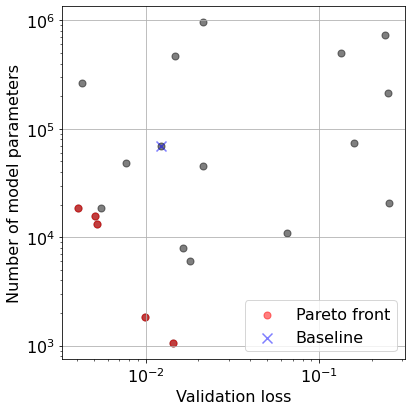

In [15]:
from deephyper.skopt.moo import pareto_front, hypervolume

objvals = -np.asarray(results_2.filter(regex=r"^objective_\d+$").values)
pf_vals = pareto_front(objvals)
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 16})
plt.scatter(objvals[:, 0], objvals[:, 1], c='k', alpha=0.5, s=50)
plt.scatter(pf_vals[:, 0], pf_vals[:, 1], c='r', alpha=0.5, s=50, label="Pareto front")
plt.scatter(history["val_loss"][-1], count_params(model.trainable_weights), c='b', alpha=0.5, marker='x', s=100, label="Baseline")
plt.xlabel("Validation loss")
plt.ylabel("Number of model parameters")
plt.gca().set_yscale('log')
plt.gca().set_xscale('log')
plt.grid()
plt.legend()
plt.tight_layout()

Check the validation loss and model size of the pareto-optimal configurations.

Observe the trade-off between model accuracy and size. A model with fewer parameters may not be as accurate as one with a larger number of parameters.

In [16]:
pf_vals

array([[1.42826010e-02, 1.05800000e+03],
       [9.89930332e-03, 1.82300000e+03],
       [5.22860279e-03, 1.33490000e+04],
       [5.05022844e-03, 1.58600000e+04],
       [4.03057551e-03, 1.85870000e+04]])

We can also obtain the hyperparameter configurations which produce the pareto optimal front. These configurations constitute the non-dominated set.

In [17]:
from deephyper.skopt.moo import non_dominated_set

nds = non_dominated_set(objvals, return_mask=False)
non_dominated_configurations = results_2.iloc[nds]
non_dominated_configurations

,activation,batch_size,dropout_rate,learning_rate,lstm_units,num_layers,recurrent_activation,job_id,objective_0,objective_1,timestamp_submit,timestamp_gather
12,tanh,26,0.148193,0.000692,13,1,tanh,13,-0.014283,-1058,411.430053,417.529419
11,tanh,6,0.381396,0.000435,18,1,tanh,12,-0.009899,-1823,396.198755,410.189806
18,tanh,32,0.211649,0.002924,32,2,tanh,19,-0.005229,-13349,508.394228,517.806289
15,tanh,25,0.089128,0.001632,35,2,tanh,16,-0.005050,-15860,439.494456,463.468255
17,tanh,7,0.186724,0.001377,38,2,tanh,18,-0.004031,-18587,476.671989,507.119761


## Multiobjective optimization in further detail (Time permitting)
By default, DeepHyper uses a fixed scalarization that weights all objectives equally. It is possible to override this behaviour to explore multiple combinations of weight preferences simultaneously. To demonstrate this, we will use the well-known "Fleming-Fonseca" benchmark test function in multi-objective optimization (see https://en.wikipedia.org/wiki/Test_functions_for_optimization#Test_functions_for_multi-objective_optimization).

In [18]:
nb_obj = 2
nb_dim = 3
test_problem = HpProblem()
for i in range(nb_dim):
    test_problem.add_hyperparameter((-4.0, 4.0), f"x{i}")

def test_func(x):
    f = np.zeros(nb_obj)

    f[0] = 1 - np.exp(-np.sum(np.square(x - 1 / np.sqrt(nb_dim)), axis=-1))
    f[1] = 1 - np.exp(-np.sum(np.square(x + 1 / np.sqrt(nb_dim)), axis=-1))

    return tuple(-f)

def run_test_func(config):
    x = np.array([config[k] for k in config if "x" in k])
    x = np.asarray_chkfinite(x)
    y = test_func(x)
    return y

Execute the sequential bayesian optimization function. Note that we use a `GP` as the surrogate since we're working with a continuous problem.

In [19]:
search_test_func = CBO(test_problem, run_test_func, surrogate_model="GP", log_dir="cbo-test-func-results", random_state=42)
results_test_func = search_test_func.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Visualize the objective space explored by the default DeepHyper scalarization.

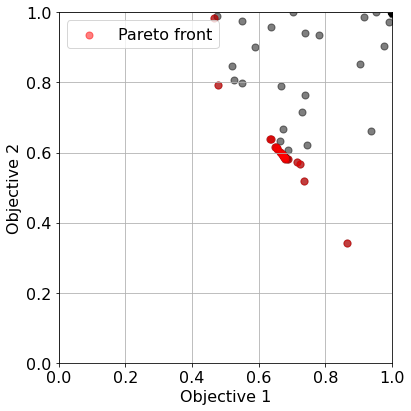

In [22]:
def plot_objective_space(results):
    fv = -np.asarray(results.filter(regex=r"^objective_\d+$").values)
    pf = pareto_front(fv)
    plt.figure(figsize=(6,6))
    plt.rcParams.update({'font.size': 16})
    plt.scatter(fv[:, 0], fv[:, 1], c='k', alpha=0.5, s=50)
    plt.scatter(pf[:, 0], pf[:, 1], c='r', alpha=0.5, s=50, label="Pareto front")
    plt.xlabel("Objective 1")
    plt.ylabel("Objective 2")
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 1])
    plt.grid()
    plt.legend()
    plt.tight_layout()
plot_objective_space(results_test_func)

Change the scalarization strategy to one that uses multiple weight vectors to scalarize the objective functions.

In [23]:
search_test_func_2 = CBO(test_problem, run_test_func, surrogate_model="GP", moo_scalarization_strategy="rChebyshev", log_dir="cbo-test-func-2-results", random_state=42)
results_test_func_2 = search_test_func_2.search(max_evals=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Let us again visualize the objectives explored by DeepHyper and note how the pareto front is more exhaustively explored in this case.

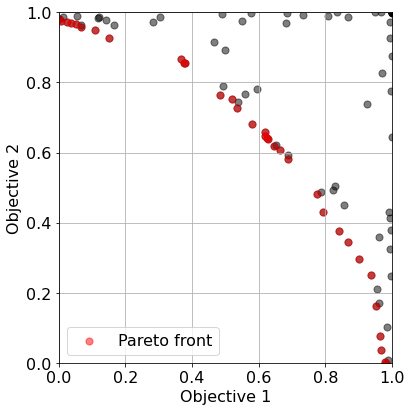

In [24]:
plot_objective_space(results_test_func_2)